In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline
from pprint import pprint

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split, learning_curve, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data = pd.read_csv('../data/train.csv')
flo_genre = pd.read_csv('../data/flo_genre_feature.csv').drop('Unnamed: 0', axis=1)
flo_age = pd.read_csv('../data/flo_age_feature.csv').drop('Unnamed: 0', axis=1)
marcel_keywords = pd.read_csv('../data/marcel_features.csv').drop('Unnamed: 0', axis=1)

data['popularity'] = np.log1p(data.popularity)
data = data.merge(flo_genre, on=['id'], how='left').merge(marcel_keywords, on=['id'], how='left').merge(flo_age, on=['id'], how='left')

data.runtime = data.runtime.fillna(np.mean(data.runtime))

features = list(flo_genre.columns) + ['popularity', 'budget', 'has_top_keyword', 'runtime']
features.remove('id')

features_df = data[features]
target = data.revenue

X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.2, random_state=42)

reg = LinearRegression()
reg.fit(X_train, np.log1p(y_train))
y_pred = np.exp(reg.predict(X_test)) - 1
np.sqrt(mean_squared_log_error(y_test, y_pred))

2.2893753446503355

In [54]:
# Define own scoring function
# because target is actually log(target)
def my_score(y_true, y_pred):
    '''
    Compute the RMSLE on the actual target values, not the log target
    '''
    if any(np.expm1(y_pred) < 0):
        return np.Infinity
    else:
        return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))
scoring_fnc = make_scorer(my_score)


# Define own scoring function
# because target is actually log(target)
# returns -error, because grid search maximizes the eval metric
def my_score_neg(y_true, y_pred):
    '''
    Compute the RMSLE on the actual target values, not the log target
    '''
    if any(np.expm1(y_pred) < 0):
        return -1 * np.Infinity
    else:
        return -1 * np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))
scoring_fnc_neg = make_scorer(my_score_neg)


def train_and_eval(model, X_train, y_train, scoring):
    cv_results = cross_validate(model, 
                                X_train, 
                                np.log1p(y_train), 
                                cv=10, 
                                scoring=scoring, 
                                return_train_score=True)
    
    mean_train = np.mean(cv_results['train_score'])
    mean_cv = np.mean(cv_results['test_score'])
    std_train = np.std(cv_results['train_score'])
    std_cv = np.std(cv_results['test_score'])

    result_summary = {
        'model': model,
        'mean_train_score': mean_train,
        'mean_cv_score': mean_cv,
        'std_train_score': std_train,
        'std_cv_score': std_cv
    }
    
    return result_summary

In [8]:
train_and_eval(reg, X_train, y_train)

{'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 'mean_train_score': 2.345453240792612,
 'mean_cv_score': 2.372933798657791,
 'std_train_score': 0.036715974160531135,
 'std_cv_score': 0.14843731942334273}

### Learning Curves

In [9]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=(10,5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring_fnc)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Cruzz\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

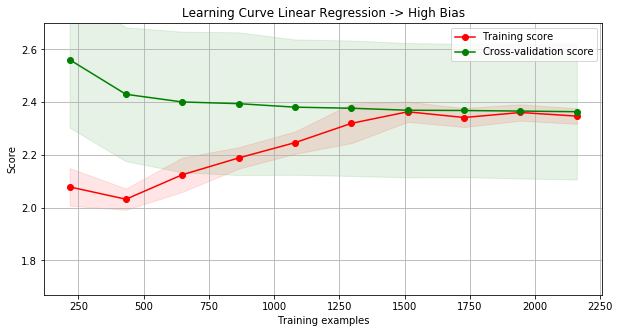

In [63]:
plot_learning_curve(reg, 'Learning Curve Linear Regression -> High Bias', X_train, np.log1p(y_train), cv=10, train_sizes=np.linspace(.1, 1.0, 10), ylim=(1.67, 2.7))

### Random Forest

{'model': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0, warm_start=False),
 'mean_train_score': 1.0164282286747883,
 'mean_cv_score': 2.3887033454193793,
 'std_train_score': 0.021376634103073625,
 'std_cv_score': 0.0965816005882214}

<module 'matplotlib.pyplot' from 'C:\\Users\\Cruzz\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

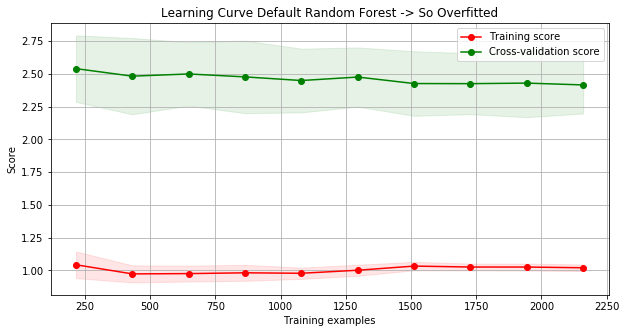

In [64]:
rf_reg = RandomForestRegressor()
display(train_and_eval(rf_reg, X_train, y_train, scoring_fnc))
plot_learning_curve(rf_reg, 'Learning Curve Default Random Forest -> So Overfitted', X_train, np.log1p(y_train), cv=10, train_sizes=np.linspace(.1, 1.0, 10))

#### GridSearch

In [79]:
# Define own scoring function
# because target is actually log(target)
# returns -error, because grid search maximizes the eval metric
def my_score_neg(y_true, y_pred):
    '''
    Compute the RMSLE on the actual target values, not the log target
    '''
    return -1 * np.sqrt(mean_squared_log_error(np.exp(y_true) - 1, np.exp(y_pred) - 1))
scoring_fnc_rf = make_scorer(my_score_neg)


# Number of trees
n_estimators = [10, 20, 30, 50, 100, 200]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [2, 3, 5, 8]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

pprint(param_grid)

rf = RandomForestRegressor()
rf_grid = GridSearchCV(rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2, scoring=scoring_fnc_neg)
rf_grid.fit(X_train, np.log1p(y_train))

{'max_depth': [2, 3, 5, 8, 13, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 10],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 20, 30, 50, 100, 200]}
Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 1022 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 2240 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 3020 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3484 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  2.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 50, 100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 3, 5, 8, 13, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(my_score_neg), verbose=2)

In [80]:
pprint(rf_grid.best_estimator_)
print(rf_grid.best_score_)
rf_reg = rf_grid.best_estimator_
display(train_and_eval(rf_reg, X_train, y_train, scoring_fnc))
plot_learning_curve(rf_reg, 'Learning Curve Tuned Random Forest', X_train, np.log1p(y_train), cv=10, train_sizes=np.linspace(.1, 1.0, 10))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
-2.2453627894737775


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
count,864.000000,8.640000e+02,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000
mean,0.114438,5.019887e-03,0.005704,0.005110,-2.121904,-2.336863,-2.490672,-2.461796,-2.326117,-2.347470,0.133139,432.500000,-2.114304,-2.064621,-2.040749,-2.047949,-2.072278,-2.067980,0.029666
std,0.150312,3.601875e-03,0.004817,0.003093,0.082870,0.092635,0.112494,0.132356,0.080798,0.095971,0.022314,249.559612,0.379294,0.367372,0.362489,0.359732,0.372919,0.367967,0.011111
min,0.003125,1.168008e-07,0.000000,0.000000,-2.526379,-2.658604,-2.913612,-2.896335,-2.658320,-2.691335,0.076653,1.000000,-2.832108,-2.680647,-2.677379,-2.654913,-2.752927,-2.682135,0.005177
25%,0.028125,1.038148e-06,0.003125,0.000001,-2.157529,-2.368787,-2.538012,-2.502936,-2.379145,-2.391610,0.118881,216.750000,-2.391051,-2.336840,-2.317740,-2.319649,-2.361538,-2.344768,0.023989
50%,0.059375,6.250048e-03,0.003125,0.006250,-2.096885,-2.302819,-2.448370,-2.415762,-2.301049,-2.305332,0.128713,432.500000,-2.191089,-2.128027,-2.110082,-2.118979,-2.131778,-2.137003,0.029099
75%,0.135156,7.654505e-03,0.009375,0.007655,-2.063178,-2.271742,-2.412140,-2.366893,-2.271839,-2.280769,0.147737,648.250000,-1.887680,-1.840492,-1.820382,-1.831818,-1.843660,-1.843090,0.033238
max,1.146870,1.874985e-02,0.025001,0.007656,-1.998471,-2.196145,-2.326142,-2.295133,-2.201576,-2.245363,0.222636,864.000000,-0.858787,-0.852545,-0.826999,-0.843796,-0.853811,-0.847513,0.122318


### Gradient Boosting

{'model': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, n_iter_no_change=None, presort='auto',
              random_state=None, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False),
 'mean_train_score': 1.8824867931832998,
 'mean_cv_score': 2.240256956853087,
 'std_train_score': 0.024213424591614092,
 'std_cv_score': 0.11577732889134486}

<module 'matplotlib.pyplot' from 'C:\\Users\\Cruzz\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

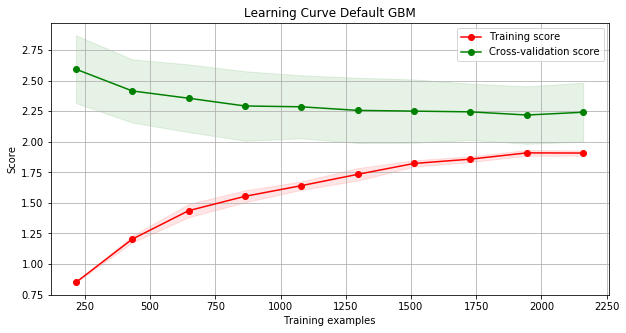

In [65]:
gb = GradientBoostingRegressor()
display(train_and_eval(gb, X_train, y_train, scoring_fnc))
plot_learning_curve(gb, 'Learning Curve Default GBM', X_train, np.log1p(y_train), cv=10, train_sizes=np.linspace(.1, 1.0, 10))

#### Grid Search

In [56]:
# Learning rate
learning_rate = [0.01, 0.1, 0.15, 0.2]

# Number of trees
n_estimators = [10, 50, 100, 200, 300]

# Max Depth
max_depth = [1, 2, 3, 5]

# Create the random grid
param_grid = {'learning_rate': learning_rate,
                'n_estimators': n_estimators, 
                'max_depth': max_depth}

pprint(param_grid)

gb = GradientBoostingRegressor()
gb_grid = GridSearchCV(gb, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2, scoring=scoring_fnc_neg)
gb_grid.fit(X_train, np.log1p(y_train))

{'learning_rate': [0.01, 0.1, 0.15, 0.2],
 'max_depth': [1, 2, 3, 5],
 'n_estimators': [10, 50, 100, 200, 300]}
Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 451 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 793 out of 800 | elapsed:   38.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   39.9s finished
C:\Users\Cruzz\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:791: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.1, 0.15, 0.2], 'n_estimators': [10, 50, 100, 200, 300], 'max_depth': [1, 2, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(my_score_neg), verbose=2)

-2.2020608694333856


{'model': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='ls', max_depth=2, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, n_iter_no_change=None, presort='auto',
              random_state=None, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False),
 'mean_train_score': 1.9518716892919485,
 'mean_cv_score': 2.241500867424684,
 'std_train_score': 0.027575288210124817,
 'std_cv_score': 0.12534712578361207}

<module 'matplotlib.pyplot' from 'C:\\Users\\Cruzz\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

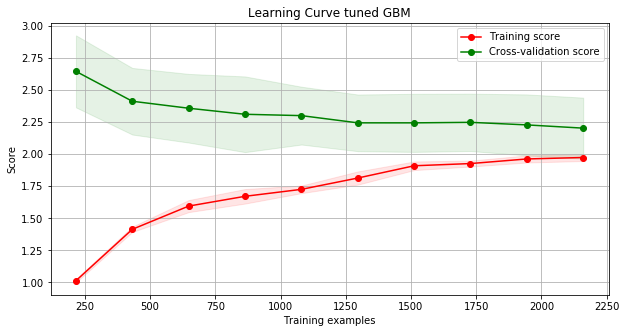

In [67]:
print(gb_grid.best_score_)
display(train_and_eval(gb_grid.best_estimator_, X_train, y_train, scoring_fnc))
plot_learning_curve(gb_grid.best_estimator_, 'Learning Curve tuned GBM', X_train, np.log1p(y_train), cv=10, train_sizes=np.linspace(.1, 1.0, 10))